# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [8]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
# env_info.vector_observations.shape : (1,37)
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as I

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Replay Buffer

Expereience tupler을 namedtuple로 표현하고 이를 deque에 저장한다.

In [2]:
from collections import namedtuple, deque
import random

class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", 
                                                               "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
        
    def sample(self):
        experience = random.sample(self.memory, k=self.batch_size)
        # 리턴되어지는 데이터가 torch tensor여야 torch로 구성한 네트워크에 쓰일 수 있다.
        # 따라서 numpy 데이터를 torch tensor로 바꾼다.
        
        # vstack을 하는 이유는 텐서의 0번째 차원이 배치 사이즈가 되게 하기 위해서이다.
        # vstack은 수직방향으로 데이터를 쌓는데 총 데이터 갯수가 0번쨰 차원이 되게 한다.
        states = torch.from_numpy(np.vstack([e.state for e in experience 
                                             if e is not None])).float().to(device)
        
        # need long Tensor for gather function.
        # sicne action is used by torch.gather(), It converts to long type.
        actions = torch.from_numpy(np.vstack([e.action for e in experience
                                             if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience
                                             if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experience
                                                 if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience
                                           if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)
        

## Networks

In [3]:
# state_size = 37
# acion_size = 4
class Network(nn.Module):
    
    def __init__(self, state_size, action_size, seed):
        
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, state_size*2)
        # I.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(state_size*2, state_size)
        self.fc3 = nn.Linear(state_size, action_size)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                I.xavier_normal_(m.weight)
                
    def forward(self, state):
        """
        Params
        ======
            state : state vector
            
        Returns
        ======
            actions : action values
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = F.relu(self.fc3(x))
        
        return actions

## Agent

In [4]:
class Agent():
    
    def __init__(self, state_size, action_size, seed, lr=1e-3, bf_size=int(1e4), batch_size=64, update_freq=4,
                gamma=0.99, tau=1e-3):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Networks
        self.qnetwork_local = Network(state_size, action_size,seed).to(device)
        self.qnetwork_target = Network(state_size, action_size, seed).to(device)
        # Optimizer
        self.optimizer = optim.Adam(params=self.qnetwork_local.parameters(), lr=lr)
        
        #Replay Memory
        self.batch_size = batch_size
        self.memory = ReplayBuffer(action_size, bf_size, self.batch_size, seed)
        
        # Initialize time step
        self.t_step = 0
        
        self.gamma = gamma
        self.tau = tau
        self.update_freq = update_freq
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every update_freq
        self.t_step = (self.t_step + 1) % self.update_freq
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
                
    def act(self, state, eps=0.0):
        # torch tensort를 만드는데 (1, batch_size, state_size) 이렇게 만든다.
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            # .data는 in-place가 아니다.
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.
        """
        states, actions, rewards, next_states, dones = experiences
        
        criterion = nn.MSELoss()
        q_estimate = self.qnetwork_local(states).gather(1, actions)
        td_target_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        td_target = rewards + gamma*(td_target_next*(1-dones))
        
        loss = criterion(q_estimate, td_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)    
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
        
        

## Train the Agent with DQN

In [5]:
#env_info = env.reset(train_mode=True)[brain_name]

In [6]:
agent = Agent(state_size=37, action_size=4, seed=0)

In [9]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [10]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [11]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    scores=[]
    scores_window = deque(maxlen=50) 
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            agent.step(state, action, env_info.rewards[0], env_info.vector_observations[0],env_info.local_done[0])
            state = env_info.vector_observations[0]
            score += env_info.rewards[0]
            if env_info.local_done[0]:
                break
        scores_window.append(score) 
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\t Score: {:.2f}'.format(i_episode, score), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    return scores


scores = dqn()            

Episode 50	Average Score: 0.16
Episode 100	Average Score: 0.90
Episode 150	Average Score: 2.02
Episode 200	Average Score: 4.44
Episode 250	Average Score: 5.54
Episode 300	Average Score: 6.66
Episode 350	Average Score: 7.68
Episode 400	Average Score: 10.46
Episode 450	Average Score: 11.94
Episode 500	Average Score: 12.26
Episode 550	Average Score: 12.32
Episode 600	Average Score: 11.42
Episode 650	Average Score: 12.06
Episode 700	Average Score: 13.00
Episode 750	Average Score: 12.46
Episode 800	Average Score: 12.98
Episode 850	Average Score: 14.06
Episode 900	Average Score: 12.96
Episode 950	Average Score: 9.48
Episode 1000	Average Score: 10.86
Episode 1050	Average Score: 13.54
Episode 1100	Average Score: 14.16
Episode 1150	Average Score: 14.22
Episode 1200	Average Score: 14.18
Episode 1250	Average Score: 14.40
Episode 1300	Average Score: 13.60
Episode 1350	Average Score: 14.04
Episode 1400	Average Score: 13.98
Episode 1450	Average Score: 14.52
Episode 1500	Average Score: 14.00
Episode 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

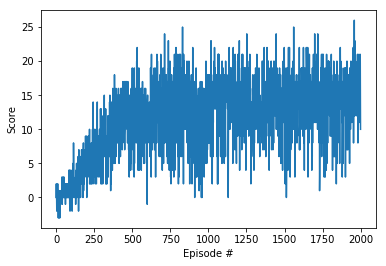

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()